# Part 1 - Reading in the data

## Part 1.1

In [19]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the data files
DATA_PATH = './data'
fn = f'{DATA_PATH}/SCE*.csv'

dfs=[]

# Loop through files and read them into a list of DataFrames
for i in glob.glob(fn):
    d = pd.read_csv(i, parse_dates=['date'],sep=';')
    dfs.append(d)

# Concatenate all DataFrames into a single DataFrame, and convert 'date' column to datetime
df_original = pd.concat(dfs)

## Part 1.2

In [20]:
def overview_stats(data):

    # Finding number of unique users
    unique_ids = data['userid'].nunique()
    print(f'Number of unique users: {unique_ids}')

    # Finding number of data rows
    data_rows = data.shape[0]
    print(f'Number of data rows: {data_rows}')

    # Finding number of unique waves
    unique_waves = data['wid'].nunique()
    print(f'Number of unique waves: {unique_waves}')

    # Finding date range
    first_date = data['date'].min()
    last_date = data['date'].max()

    # Printing first and last dates observed
    print(f'Data ranges from {first_date.date()} to {last_date.date()}')
    
    return None

overview_stats(df_original)

Number of unique users: 23369
Number of data rows: 176101
Number of unique waves: 139
Data ranges from 2013-06-01 to 2024-12-31


# Part 2

## Part 2.1

In [21]:
# Sort by 'userid' and 'date'
# Creating new dataframe (df) to avoid modifying original dataframe (df_original)

df = df_original.sort_values(["userid", "date"], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])

#Could have looped through columns but this is clearer
num_cols = [c for c in df.columns if "num_lit_" in c and "_correct" in c]

# Fill missing values with the first observed value per user
df[num_cols] = (
    df.groupby("userid", group_keys=False)[num_cols]
      .apply(lambda g: g.ffill().bfill())
)



## Part 2.2 (Need improvements)

In [22]:
# Dropping rows with missing values in specified subsets of columns
demo = ['age', 'female', 'educ']
expectation = ['inflation', 'house_price_change', 'prob_stocks_up']

subsets = [
    ("demo", demo),
    ("expectation", expectation),
    ("numeracy", num_cols)
]

total = 0

for name, ss in subsets:
    before = df.shape[0]
    df = df.dropna(subset=ss, ignore_index=True)
    after = df.shape[0]
    total += (before - after)
    print(f"Numbers before dropping NAs for {name}: {before}, after: {after}, dropped: {before - after}")

print(f'\nTotal rows dropped: {total}')

Numbers before dropping NAs for demo: 176101, after: 175233, dropped: 868
Numbers before dropping NAs for expectation: 175233, after: 173550, dropped: 1683
Numbers before dropping NAs for numeracy: 173550, after: 137576, dropped: 35974

Total rows dropped: 38525


## Part 2.3

In [23]:
# Creating a function to drop observations below 0.1th and above 99.9th percentile for each expectation variable
def drop_outliers(data, columns):
    for col in columns:

        # Calculate percentiles and find number of rows before dropping
        before = data.shape[0]
        low = data[col].quantile(0.001)
        high = data[col].quantile(0.999)

        # Filter data to keep only rows within the percentile range, and calculate number of dropped rows
        data = data.query(f"{col} > {low} and {col} < {high}")
        dropped = before - data.shape[0]

        # Print results
        print(f"{col.capitalize()}: 0.1th percentile = {low}, 99.9th percentile = {high}")
        print(f"Observations dropped for {col}: {dropped}\n")
    
    # Return the cleaned data without outliers
    return data

drop_outliers(df, expectation)

Inflation: 0.1th percentile = -75.0, 99.9th percentile = 100.0
Observations dropped for inflation: 434

House_price_change: 0.1th percentile = -50.0, 99.9th percentile = 100.0
Observations dropped for house_price_change: 418

Prob_stocks_up: 0.1th percentile = 0.0, 99.9th percentile = 100.0
Observations dropped for prob_stocks_up: 2456



,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q3,num_lit_q3_correct,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct
0,70057317,201504,2015-04-10,0.5,0.0,4.0,70.0,0.0,0.0,1.0,...,10.0,1.0,10.0,0.0,5.0,1.0,3.0,1.0,2.0,1.0
1,70057321,201504,2015-04-05,0.5,1.0,4.0,72.0,0.0,0.0,0.0,...,10.0,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0
2,70057321,201505,2015-05-11,0.5,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0
3,70057321,201506,2015-06-20,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0
4,70057321,201507,2015-07-22,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137571,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,10.0,1.0,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0
137572,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,10.0,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0
137573,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,10.0,1.0,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0
137574,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,10.0,1.0,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0


## Part 2.4

In [24]:
# Creating a dummy variable for bachelors degree
df['college'] = (df['educ'] == 4).astype(int)

## Part 2.5

In [25]:
num_correct = df.groupby("userid")[num_cols].first().sum(axis=1)

# value counts normalized to fractions
fraction = num_correct.value_counts(normalize=True).sort_index() * 100

# display results
summary = fraction.rename("percent").reset_index().rename(columns={"index": "num_correct"})
print(summary)

   num_correct    percent
0          0.0   0.146727
1          1.0   0.727991
2          2.0   2.404063
3          3.0   5.727991
4          4.0  10.519187
5          5.0  16.930023
6          6.0  27.409707
7          7.0  36.134312


In [26]:
#Create a new column num_lit_high (“high numerical literacy”) equal to 1 if an individual had
#more correct responses than the median, and 0 otherwise."
median_num_correct = num_correct.median()
num_lit_high = (num_correct > median_num_correct).astype(int)

# add it to the dataframe by userid
df['num_lit_high'] = df['userid'].map(num_lit_high)

df

,userid,wid,date,weight,female,educ,age,hispanic,black,couple,...,num_lit_q5,num_lit_q5_correct,num_lit_q6,num_lit_q6_correct,num_lit_q8,num_lit_q8_correct,num_lit_q9,num_lit_q9_correct,college,num_lit_high
0,70057317,201504,2015-04-10,0.5,0.0,4.0,70.0,0.0,0.0,1.0,...,10.0,0.0,5.0,1.0,3.0,1.0,2.0,1.0,1,0
1,70057321,201504,2015-04-05,0.5,1.0,4.0,72.0,0.0,0.0,0.0,...,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1,1
2,70057321,201505,2015-05-11,0.5,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,1
3,70057321,201506,2015-06-20,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,1
4,70057321,201507,2015-07-22,0.4,1.0,4.0,72.0,0.0,0.0,0.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137571,75025299,202412,2024-12-19,0.6,1.0,3.0,33.0,0.0,0.0,1.0,...,100.0,1.0,5.0,1.0,2.0,0.0,2.0,1.0,0,0
137572,75025320,202412,2024-12-05,0.8,1.0,4.0,56.0,1.0,0.0,0.0,...,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,1,0
137573,75025337,202412,2024-12-21,1.0,1.0,3.0,68.0,0.0,0.0,1.0,...,100.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,0,1
137574,75025373,202412,2024-12-09,2.4,1.0,2.0,58.0,0.0,0.0,0.0,...,100.0,1.0,1.0,0.0,3.0,1.0,2.0,1.0,0,0


## Part 2.6

In [27]:
#Use function to print overview statistics of cleaned data
overview_stats(df)

Number of unique users: 17720
Number of data rows: 137576
Number of unique waves: 117
Data ranges from 2015-04-02 to 2024-12-31


# Part 3

## Part 3.1

In [28]:
def analyze_expectations_by_group(data, group_var, group_labels):
    """
    Calculate average expectations by group.
    
    Parameters:
    - data: DataFrame containing the data
    - group_var: string, column name for grouping ('female', 'college', 'num_lit_high')
    - group_labels: tuple of strings for group labels
    """
    # Calculate means for each expectation variable by group
    means = data.groupby(group_var)[expectation].mean()
    
    # Rename index values to more descriptive labels
    means.index = group_labels
    
    # Round to 2 decimal places for cleaner output
    means = means.round(1)
    
    print(f"\nAverage Expectations by {group_var.capitalize()}:")
    return means

In [29]:
def plot_expectations_by_group(data, group_var, group_labels, title):
    """
    Create bar plots of expectations by group with specific y-axis ranges.
    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 5))
    fig.suptitle(f'{title}', fontsize=14)

    # Define y-axis ranges for each expectation variable
    ylims = {
        'inflation': (0, 15),
        'house_price_change': (0, 15),
        'prob_stocks_up': (0, 100)
    }

    # Use the analyze_expectations_by_group function to get means for all expectation vars
    means_df = analyze_expectations_by_group(data, group_var, group_labels)

    for i in range(3):
        expectation_var = expectation[i]

        # Extract the series of means for the current expectation variable
        means = means_df[expectation_var]

        # Create bar plot and set title
        axes[i].bar(group_labels, means.values, color=['skyblue', 'salmon'])
        axes[i].set_title(expectation_var.replace('_', ' ').capitalize())

        # Set y-axis labels and limits
        axes[i].set_ylabel('Expectation (%)' if i < 2 else 'Probability (%)')

        # Set specific y-axis range for the expectation variable (e.g., inflation...)
        axes[i].set_ylim(ylims[expectation_var])  

        # Show values on top of bars. Uses enumarate to 
        for n, value in enumerate(means.values):
            axes[i].text(n,                                                    # x-coordinate
                        value + (ylims[expectation_var][1] * 0.02),            # y-coordinate relative to y-lim
                        f'{value}%',                                           # Text content
                        ha='center',                                           # Horizontal alignment = Center
                        va='bottom')                                           # 

    plt.tight_layout()
    plt.show()


Average Expectations by Female:


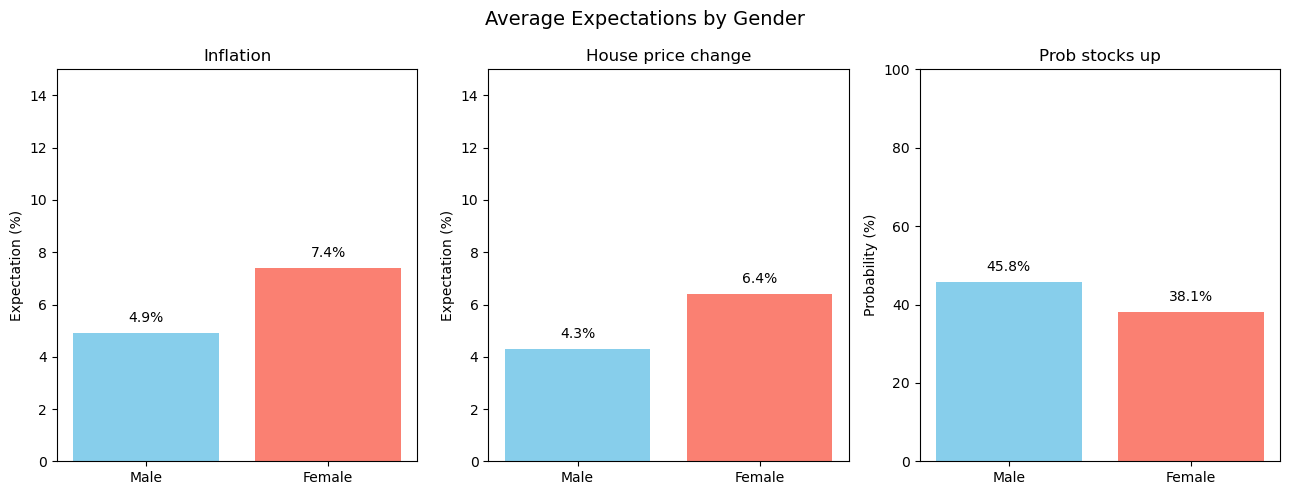

In [30]:
# Plot expectations by gender
plot_expectations_by_group(df, 'female', ('Male', 'Female'), "Average Expectations by Gender")


Average Expectations by College:


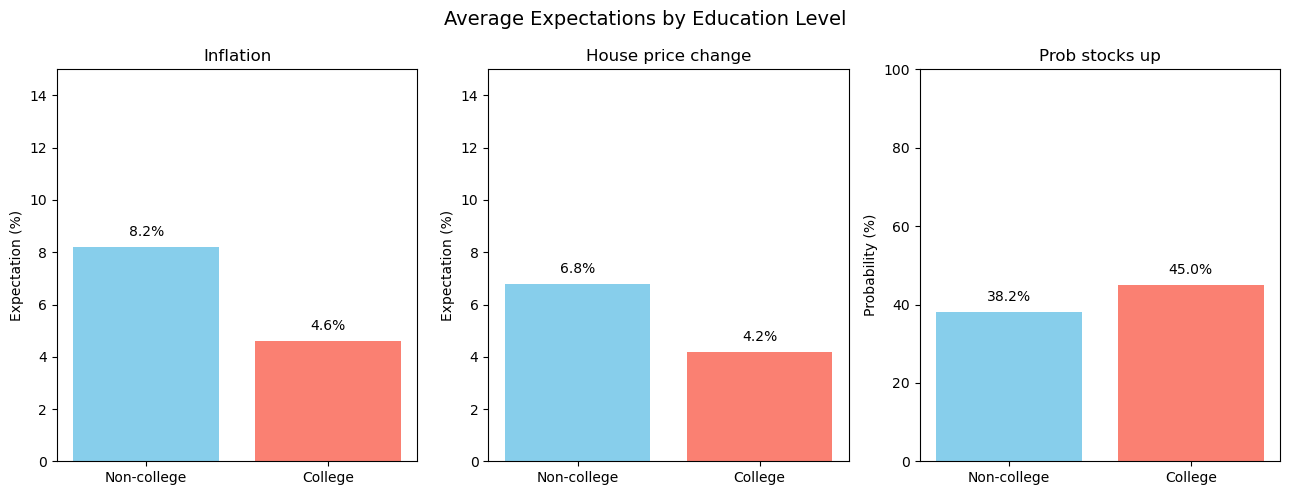

In [31]:
plot_expectations_by_group(df, 'college', ('Non-college', 'College'), 'Average Expectations by Education Level')


Average Expectations by Num_lit_high:


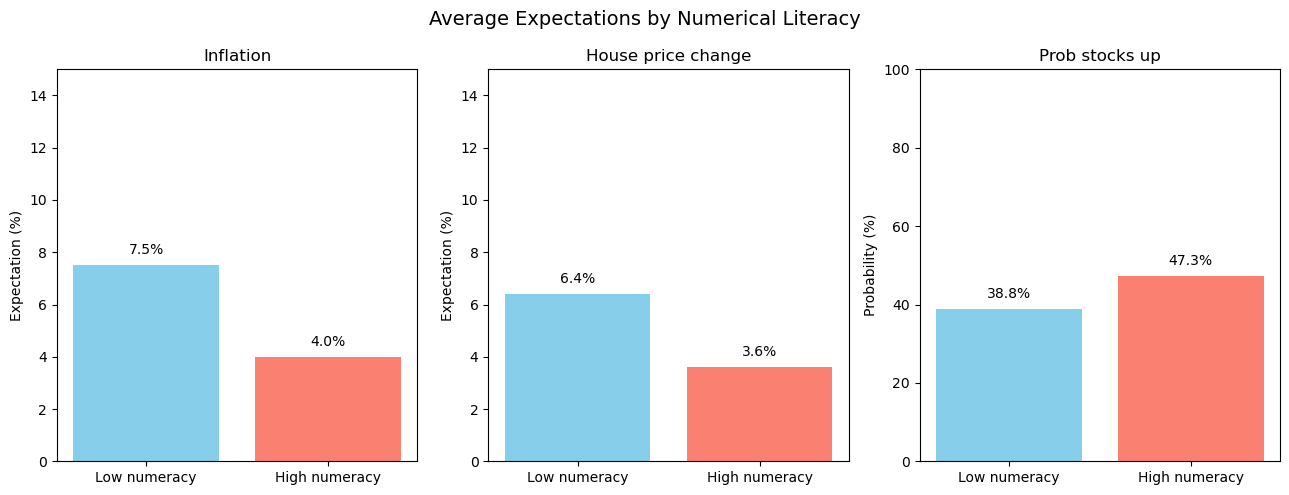

In [32]:
plot_expectations_by_group(df, 'num_lit_high', ('Low numeracy', 'High numeracy'), 'Average Expectations by Numerical Literacy')

## Conclusion: Task 3 — How do expectations differ by gender, education, and numeracy?

The results reveal consistent differences in expectations across groups.

---

#### **Gender**
As shown in the graph, women expect around 7.4% inflation and 6.4% house price growth, compared to men's 4.9% and 4.3%, respectively. They also assign a lower probability (≈38%) that stocks will rise versus men (≈45%). This indicates that women are generally more concerned about rising prices and more cautious toward stock market risk.

#### **Education Level**
The graph shows that non-college respondents expect about 8% inflation and 7% house price growth, while college-educated individuals predict around 4.5% and 4%. College-educated respondents also expect a higher 45% probability that stocks will increase, compared to 38% for non-college participants. This suggests that higher education is linked to more moderate and economically grounded expectations.

#### **Literacy Level**
As shown in the graph, people with low numeracy expect around 7.5% inflation and 6.4% house price growth, while high-numeracy individuals expect only about 4% and 3.6%, respectively. This likely reflects that people with stronger numerical skills make more realistic, data-based judgments. Similarly, high-numeracy individuals see about a 47% chance of stock prices rising, compared to 39% for low numeracy, suggesting they better understand market probabilities.

---

### Summary

Overall, people with higher numeracy or education have more moderate and realistic expectations: lower predicted inflation and house price growth but higher confidence in the stock market. In contrast, those with lower numeracy, less education, or women expect higher prices and show more caution toward financial risk.

# Task 4

## Task 4.1

In [33]:
def monthly_group_means(df, group_col, date_col="date"):
    """
    Calculates monthly averages of expectation variables for each group.

    Returns three DataFrames (infl, house, stock),
    each showing average values per group for each month (2015–2024).
    """

    # Keep only the relevant columns (date, group, and expectation variables)
    df_monthly = df[[date_col, group_col] + expectation].copy()

    # Convert date column to datetime format
    df_monthly[date_col] = pd.to_datetime(df_monthly[date_col])

    # Group by month and group value, then compute the mean of expectation columns
    gb = df_monthly.groupby([pd.Grouper(key='date', freq='ME'), group_col])[expectation].mean()

    # For each expectation variable, reshape so that:
    #   rows = months, columns = groups
    #   then limit the range to Jan 2015 – Dec 2024
    inflation, house_price, stock_prob = (
        gb[var].unstack(group_col).loc["2015-01":"2024-12"]
        for var in expectation
    )

    # Return the three DataFrames
    return inflation, house_price, stock_prob


## Task 4.2

In [ ]:
"""

Create a figure with three vertically stacked panels (one panel per expectation variable). Each
panel should show the group time series (two series per panel, e.g., males vs. females) with time
on the x-axis. Use the function monthly_group_means to get the data for plotting.

"""

# def plot_monthly_group_means(df, group_col, group_labels, custom_title, date_col="date"):
#     # Get the monthly group means for each expectation variable
#     infl, house, stock = monthly_group_means(df, group_col, date_col)

#     # Create a figure with three vertically stacked panels
#     fig, axes = plt.subplots(3, 1, figsize=(14, 18))

#     # Plot each expectation variable in its respective panel
#     for i, (data, title) in enumerate(zip([infl, house, stock],
#                                           ['Inflation', 'House Price Change', 'Stock Market Increase'])):
#         axes[i].plot(data.index, data[0], label=group_labels[0], linewidth=2)
#         axes[i].plot(data.index, data[1], label=group_labels[1], linewidth=2)
#         axes[i].set_title(title, fontsize=14)
#         axes[i].set_ylabel('Expectation (%)' if i < 2 else 'Probability (%)', fontsize=12)
#         axes[i].legend()
#         axes[i].grid(True, alpha=0.3)

#     # Set x-axis label on the bottom panel
#     axes[2].set_xlabel('Date')
#     axes[1].axhline(0, color='black', lw=0.8)
#     fig.suptitle(custom_title, fontsize=16, y=1.00)

#     for event_name, event_date in events.items():
#         for ax in axes:
#             ax.axvline(event_date, color='red', linestyle='--', alpha=0.5, linewidth=1.2)
#             # place label slightly above the top of the plot area
#             bottom, top = ax.get_ylim()
#             span = top - bottom
#             ax.text(event_date, top + span * 0.02, event_name, rotation=90,
#                     ha='center', va='bottom', fontsize=8, alpha=0.7)
    
#     plt.tight_layout()
#     plt.show()

In [39]:
def create_monthly_group_plot(df, group_col, group_labels, custom_title, date_col="date"):
    """
    Create the 3-panel monthly group means plot and return (fig, axes).
    Does not add event lines so they can be layered later.
    """
    infl, house, stock = monthly_group_means(df, group_col, date_col)

    fig, axes = plt.subplots(3, 1, figsize=(14, 18))

    for i, (data, title) in enumerate(
        zip([infl, house, stock], ["Inflation", "House Price Change", "Stock Market Increase"])
    ):
        cols = data.columns.tolist()
        # plot both group series (assumes two groups; uses whatever columns are present)
        axes[i].plot(data.index, data[cols[0]], label=group_labels[0], linewidth=2)
        axes[i].plot(data.index, data[cols[1]], label=group_labels[1], linewidth=2)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_ylabel("Expectation (%)" if i < 2 else "Probability (%)", fontsize=12)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    axes[2].set_xlabel("Date")
    axes[1].axhline(0, color="black", lw=0.8)
    fig.suptitle(custom_title, fontsize=16, y=1.00)

    return fig, axes

In [38]:
events = {
    'Trump elected (1st)': pd.Timestamp('2016-11-08'),
    'COVID-19 global': pd.Timestamp('2020-02-01'),
    'Biden elected': pd.Timestamp('2020-11-03'),
    'Russia invades Ukraine': pd.Timestamp('2022-02-24'),
    'Jon Fosse Nobel Prize': pd.Timestamp('2023-10-03'),
    'Trump elected (2nd)': pd.Timestamp('2024-11-05')
}

In [37]:
def add_event_lines(axes, events, y_offset=0.02, color="red", linestyle="--", alpha=0.5, linewidth=1.2, fontsize=8):
    """
    Add vertical event lines and rotated labels to an existing axes array.
    - axes: array-like of matplotlib Axes
    - events: dict-like {name: pd.Timestamp}
    - y_offset: fraction of axis height to place the label above the top
    """
    for event_name, event_date in events.items():
        for ax in axes:
            ax.axvline(event_date, color=color, linestyle=linestyle, alpha=alpha, linewidth=linewidth)
            bottom, top = ax.get_ylim()
            span = top - bottom
            ax.text(
                event_date,
                top + span * y_offset,
                event_name,
                rotation=90,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                alpha=0.7,
            )

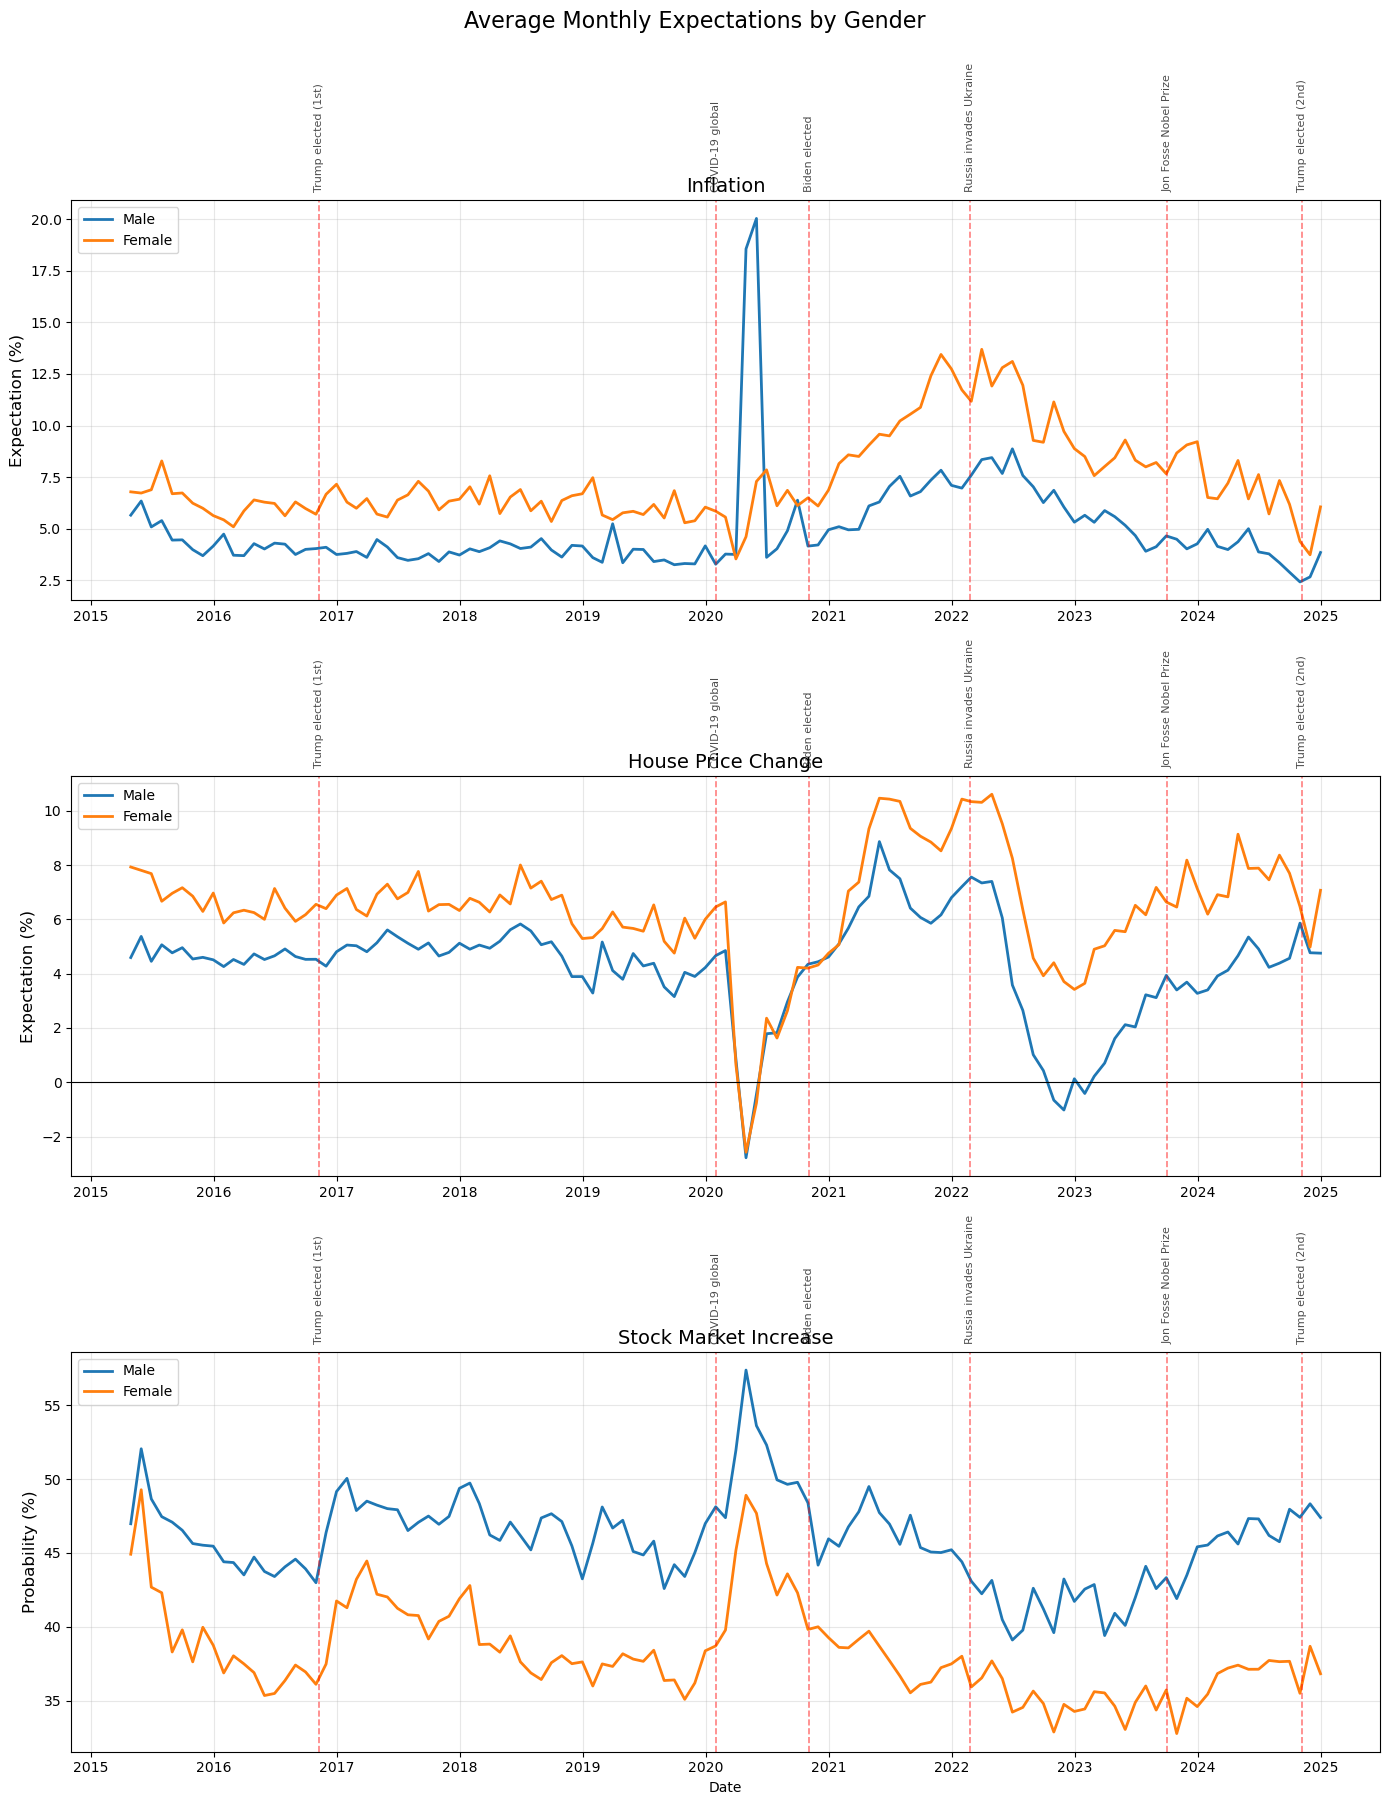

In [40]:
fig, axes = create_monthly_group_plot(df, "female", ("Male", "Female"), "Average Monthly Expectations by Gender")
add_event_lines(axes, events)          # events dict should be defined (as in your notebook)
plt.tight_layout()
plt.show()